Nikos Vougioukakis
Assignment 2

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# question A

In [327]:
L_values = [0,1,2,3,5,7,10,50,100,200,300,500,750,1000,1500,2000,2500,2750,3000,3050,3100,3150,3200,3250,3300,3350]

In [328]:
def train_NBC(X, X_dtype, Y, L=0, D_categorical=None, plots=False):
    """
    Inputs
    ------
    • `X` : IxM matrix of variables. Rows correspond to the I samples and columns
    to the M variables.
    • `X_dtype` : String describing the data type of X, which could be either ”cate-
    gorical” or ”continuous”.
    • `Y` : Ix1 vector. Y is the class variable you want to predict.
    • `L` : Scalar. L is the parameter referred to in the MAP estimates equation.
    For L = 0 you get the MLE estimates. L ≥ 0. Default value = 0.
    • `D_categorical`: 1xM vector. Each element D(m) contains the number of pos-
    sible different values that the categorical variable m can have. This vector is
    ignored if X dtype = ”continuous”. Default = None
    - `plots` (bool): If you want to plot for question (d)

    Output
    ------
    • `Model`: This model should contain all the parameters required by the NBC
    to classify new samples. It is up to you to decide its structure. The only
    requirement is that it is compatible with your next function.

    for categorical :
    
    - model[0] : theta_ijk parameters list[list[dict]]
    - model[1] : pi_k parameters dict 
    - model[2] : class values
    - model[3] : array of probabilities of every feature Xi, P(Xi = 0 | Y=0), only if plots=True
    - model[4] : array of probabilities of every feature Xi, P(Xi = 1 | Y=1), only if plots=True


    Notes for Categorical values:
    -----------------------------
    • All categorical variables take values starting from 0. If a variable can take K
    possible values, its values are in [0, K-1]. This holds for both the class values
    in Y and the values in X.
    • If some combinations of values do not occur in the data they take probability
    0, unless L is greater than 0.
    • D categorical − It is important to pass this information to the function be-
    cause the samples used for training do not necessarily contain all possible
    values that the variables can take.
    """

    model = [] # [ theta, pi, classes ]
    
    if X_dtype == "categorical":
        if D_categorical is None:
            raise ValueError('D_categorical must be provided for categorical data')

        # useful variables
        n_samples, n_features = X.shape

        classes = np.unique(Y) #-> sorted array of class VALUES
        n_classes = len(classes)


        # initialize θ_ijk list of lists of dictionaries
        params_x_given_y = [[ dict.fromkeys(classes, 0) for j in range(D_categorical[i])] for i in range(n_features)]
                # -> theta [ feature : int] [ feature value : int ] [ class : anything]

        ### learning parameters π_k ###
        # number of { Y = y_k }

        params_y = { cls : 0 for cls in classes}
        class_counts = {cls : 0 for cls in classes}

        for cls in classes:
            count = 0
            for elem in Y:
                if elem == cls:
                    count += 1
            class_counts[cls] = count
            params_y[cls] = (count + L) / (n_samples + L*n_classes) 
        
        ### learning parameters θ_ijk ###
        for feature in range(n_features): # feature i, use D_categorical[i] to know how many values it takes
            for feature_value in np.unique(X[:,feature]): # -> sorted array of the unique values feature i takes
                                                        # this is used for training, so we don't need to check for the
                                                        # values we dont see in the train set, probability will remain zero

                for cls in classes:
                    count = 0 # numerator = number of { X_i = x_ij AND Y = y_k }
                    
                    for row in range(n_samples): # we count for all samples
                        if X[row, feature] == feature_value and Y[row] == cls:
                            count += 1
                    
                    theta_ijk =  (count + L) / (class_counts[cls] + L * D_categorical[feature])
                    params_x_given_y[feature][feature_value][cls] = theta_ijk

        

        ### this part is for question (d) ###

        # probabilities P(Xi = 0 | Y = cls) for every feature
        probabilities_0 = []
        probabilities_1 = []
        if plots:

            #plot the barplots
            #fig, axs = plt.subplots(2, n_features, figsize=(4 * n_features, 8))

            for cls in [0, 1]:

                for feature in range(n_features):
                    feature_values = np.unique(X[:, feature])
                    y_values = [params_x_given_y[feature][value][cls] for value in feature_values]
                    if cls==0: probabilities_0.append(params_x_given_y[feature][0][cls])
                    else: probabilities_1.append(params_x_given_y[feature][0][cls])

                    #plot
                    #ax = axs[cls, feature]
                    #ax.bar(feature_values, y_values)
                    ##ax.set_ylim(0, 1)

            #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            #plt.show()
        

        model.append(params_x_given_y)
        model.append(params_y)
        model.append(classes)
        model.append(probabilities_0)
        model.append(probabilities_1)
        return model
    
    elif X_dtype == 'continuous':
        
        # useful variables
        n_samples, n_features = X.shape

        classes = np.unique(Y) #-> sorted array of class VALUES
        n_classes = len(classes)

        class_counts : dict = {cls : 0 for cls in classes} #-> dict, key = class , value = how many times it appears in Y
                        # e.g. { class0: 54, class1: 82, ...}
        for cls in classes:
            count = np.sum(Y == cls)
            class_counts[cls] = count
        
        # initialize μ_ik and variances as a dictionary of lists like this:
        # means = { 'class0' : [μ feat0, μ feat1,...], 
        #           'class1' : [μ feat0,...],
        #          ...}
        # all means and variances for all features are initialized as zero

        means = {cls : [0 for feature in range(n_features)] for cls in classes}
        variances = {cls : [0 for feature in range(n_features)] for cls in classes}

        ### learning parameters π_k ###
        # number of { Y = y_k }

        params_y = { cls : 0 for cls in classes}
        for cls in classes:
            params_y[cls] = class_counts[cls] / n_samples
        
        ### learning parameters μ_ik, σ squared ###
        for feature in range(n_features):
            for cls in classes:
                sum = 0 # numerator = sum of rows for which Yk = cls
                sum_squares = 0 # for variance
                
                for row in range(n_samples): # we count for all samples - rows
                    if Y[row] == cls:
                        sum += X[row,feature]
                        sum_squares += X[row,feature]**2

                mean_ik = sum / class_counts[cls]  # = Sum (xi) / n
                means[cls][feature] = mean_ik

                var_ik = sum_squares / class_counts[cls] - mean_ik**2  # = Sum (xi)^2 / n  - mean^2
                variances[cls][feature] = var_ik

        model.append(means)
        model.append(variances)
        model.append(params_y)
        model.append(classes)
        

        return model
    else:
        raise ValueError('Invalid data type. X dtype should be either "categorical" or "continuous".')




# question B

In [329]:
def predict_NBC(model, X, X_dtype)->np.ndarray:
    """
    Inputs
    -------
    • `model` - list: The model previously trained using train NBC.
    • `X`: JxM matrix of variables. Rows correspond to the J samples and columns
    to the M variables.
    • `X dtype`: String describing the data type of X, which could be either ”cate-
    gorical” or ”continuous”.

    Output
    ------
    • `predictions`: Jx1 vector. Contains the predicted class for each input samples.
    """

    if X_dtype == 'categorical':

        predictions = []
        theta = model[0]
        pi = model[1]
        classes = model[2]


        for sample in X: #-> iterates over rows
            max_prob = -np.inf
            predicted_class = None

            for cls in classes:
                
                prob = np.log(pi[cls])
                for feature in range(len(sample)):
                    # using log to avoid numerical underflow
                    prob += np.log(theta[feature][sample[feature]][cls])

                if prob > max_prob:
                    max_prob = prob
                    predicted_class = cls
                    
            predictions.append(predicted_class)
        return np.array(predictions)
    
    elif X_dtype == 'continuous':
        predictions = []
        means = model[0]
        variances = model[1]
        params_y = model[2]
        classes = model[3]

        for sample in X: #-> iterates over rows
            max_prob = -np.inf
            predicted_class = None

            for cls in classes:
                prob = np.log(params_y[cls])
                for feature in range(len(sample)):
                    # using log to avoid numerical underflow
                    # prob here is the sum of the logs of gaussians
                    prob += np.log(1 / np.sqrt(2 * np.pi * variances[cls][feature])) + (-1 / (2 * variances[cls][feature])) * (sample[feature] - means[cls][feature])**2

                if prob > max_prob:
                    max_prob = prob
                    predicted_class = cls
                    
            predictions.append(predicted_class)

        return np.array(predictions)
    else:
        raise ValueError('Invalid data type. X dtype should be either "categorical" or "continuous"')


# question C

In [330]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB

### loading datasets

In [331]:
datasetA_X_categorical = pd.read_csv('DatasetA_X_categorical.csv', header=None)
datasetA_Y = pd.read_csv('DatasetA_Y.csv', header=None)
datasetA_D_categorical = pd.read_csv('DatasetA_D_categorical.csv', header=None)

# first i convert everything to numpy array
datasetA_X_categorical = datasetA_X_categorical.to_numpy()
datasetA_Y = datasetA_Y.to_numpy().flatten()
datasetA_D_categorical = datasetA_D_categorical.to_numpy().flatten()


In [332]:
datasetB_X_continuous = pd.read_csv('DatasetB_X_continuous.csv', header=None)
datasetB_Y = pd.read_csv('DatasetB_Y.csv', header=None)

# first i convert everything to numpy array
datasetB_X_continuous = datasetB_X_continuous.to_numpy()
datasetB_Y = datasetB_Y.to_numpy().flatten()

In [333]:
def shuffle(a, b):
    """returns copies of the randomly shuffled versions of the arrays. """
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [334]:
def question_C_continuous(X, Y, K: int = 100) -> float:
    """
    Split data into train and test parts (25-75).
    Train, test and find the accuracy.
    Repeat K times.

    Parameters
    ----------
    - `X` (np.ndarray): input data 
    - `Y` (np.ndarray): labels for the input data
    - `K` (int): the number of folds to split your data into
    - `trace` (boolean) : choose whether you want output of the error at each iteration

    Returns:
    --------
    Prints the results and returns
    """
    results = []
    i = 0

    times_equal = 0  # to keep track of how many times the predictions match sklearn's Naive Bayes predictions

    
    while i<K:
        # shuffle data
        X, Y = shuffle(X, Y)
        
        #split the arrays into 75% and 25% parts
        train_size = int(0.75 * X.shape[0])
        X_train = X[:train_size]
        X_test = X[train_size:]
        Y_train = Y[:train_size]
        Y_test = Y[train_size:]

        # model
        model = train_NBC(X=X_train, X_dtype='continuous', Y=Y_train)
        predictions = predict_NBC(model, X_test, 'continuous')
        accuracy = np.sum(Y_test == predictions)
        results.append(accuracy)

        # comparison with sklearn's naive bayes

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train, Y_train)
        Y_pred = nb_classifier.predict(X_test)

        are_equal = np.array_equal(Y_pred, predictions)
        if are_equal: times_equal += 1

        i += 1
    
    print(f'Output: \n Average accuracy: {np.mean(results)} % \n Times same results with sklearn: {times_equal}/{K}')    

In [335]:
def question_C_categorical(X, Y, D, K: int = 100) -> float:
    """
    Split data into train and test parts (25-75).
    Train, test and find the accuracy.
    Repeat K times.

    Parameters
    ----------
    - `X` (np.ndarray): input data 
    - `Y` (np.ndarray): labels for the input data
    - `D` (np.ndarray): categorical feature number of values
    - `K` (int): the number of folds to split your data into
    - `trace` (boolean) : choose whether you want output of the error at each iteration

    Returns
    -------
    mean accuracy for each value of L in [0,1,5,10,50,100, 300, 1000, 2000, 3000]
    """
    
    mean_accuracy_for_L_vals = []
    for l in L_values:
        results = []
        i = 0
        times_equal = 0  # to keep track of how many times the predictions match sklearn's Naive Bayes predictions

        while i<K:
            # shuffle data
            X, Y = shuffle(X, Y)
            
            #split the arrays into 75% and 25% parts
            train_size = int(0.75 * X.shape[0])
            X_train = X[:train_size]
            X_test = X[train_size:]
            Y_train = Y[:train_size]
            Y_test = Y[train_size:]
            D_category_train = datasetA_D_categorical[:train_size]

            # my model results
            model = train_NBC(X=X_train, X_dtype='categorical', Y=Y_train, D_categorical=D_category_train,L=l)
            predictions = predict_NBC(model, X_test, 'categorical')
            accuracy = np.sum(Y_test == predictions)
            results.append(accuracy)

            # sklearn results

            nb_classifier = CategoricalNB()
            nb_classifier.fit(X_train, Y_train)
            Y_pred = nb_classifier.predict(X_test)

            are_equal = np.array_equal(Y_pred, predictions)
            if are_equal: times_equal += 1

            i += 1
        mean_accuracy_for_L_vals.append(np.mean(results))
    
        print(f'Output: \n L={l} \n Average accuracy: {np.mean(results)} % \n Times same results with sklearn: {times_equal}/{K}')

    return mean_accuracy_for_L_vals

In [336]:
mean_accuracy_for_L_vals = question_C_categorical(datasetA_X_categorical, datasetA_Y, datasetA_D_categorical);

Output: 
 L=0 
 Average accuracy: 57.64 % 
 Times same results with sklearn: 87/100
Output: 
 L=1 
 Average accuracy: 57.46 % 
 Times same results with sklearn: 100/100
Output: 
 L=2 
 Average accuracy: 56.96 % 
 Times same results with sklearn: 84/100
Output: 
 L=3 
 Average accuracy: 57.96 % 
 Times same results with sklearn: 71/100
Output: 
 L=5 
 Average accuracy: 57.0 % 
 Times same results with sklearn: 59/100
Output: 
 L=7 
 Average accuracy: 57.6 % 
 Times same results with sklearn: 43/100
Output: 
 L=10 
 Average accuracy: 56.34 % 
 Times same results with sklearn: 27/100
Output: 
 L=50 
 Average accuracy: 55.2 % 
 Times same results with sklearn: 1/100
Output: 
 L=100 
 Average accuracy: 54.34 % 
 Times same results with sklearn: 0/100
Output: 
 L=200 
 Average accuracy: 52.55 % 
 Times same results with sklearn: 0/100
Output: 
 L=300 
 Average accuracy: 51.49 % 
 Times same results with sklearn: 0/100
Output: 
 L=500 
 Average accuracy: 51.86 % 
 Times same results with skle

In [337]:
question_C_continuous(datasetB_X_continuous, datasetB_Y)

Output: 
 Average accuracy: 63.55 % 
 Times same results with sklearn: 100/100


# question D

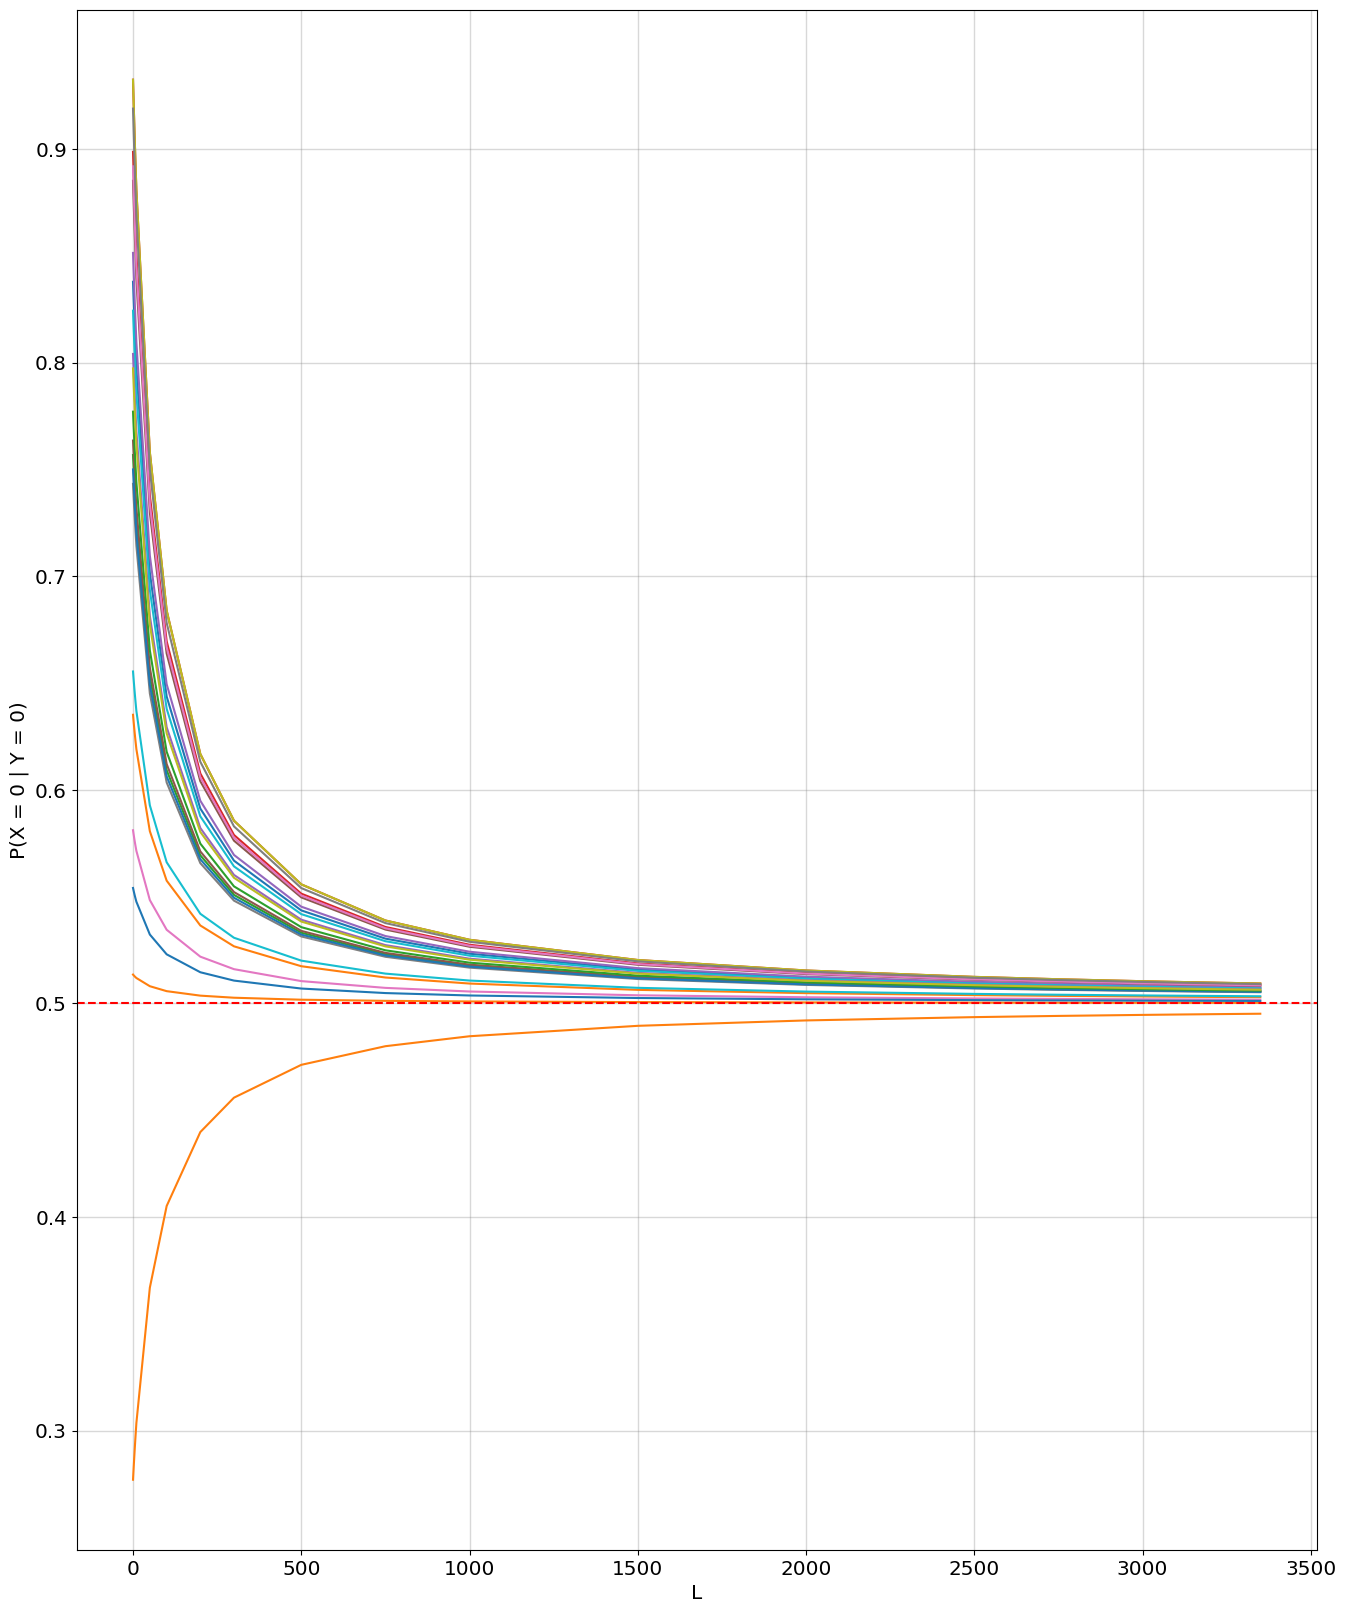

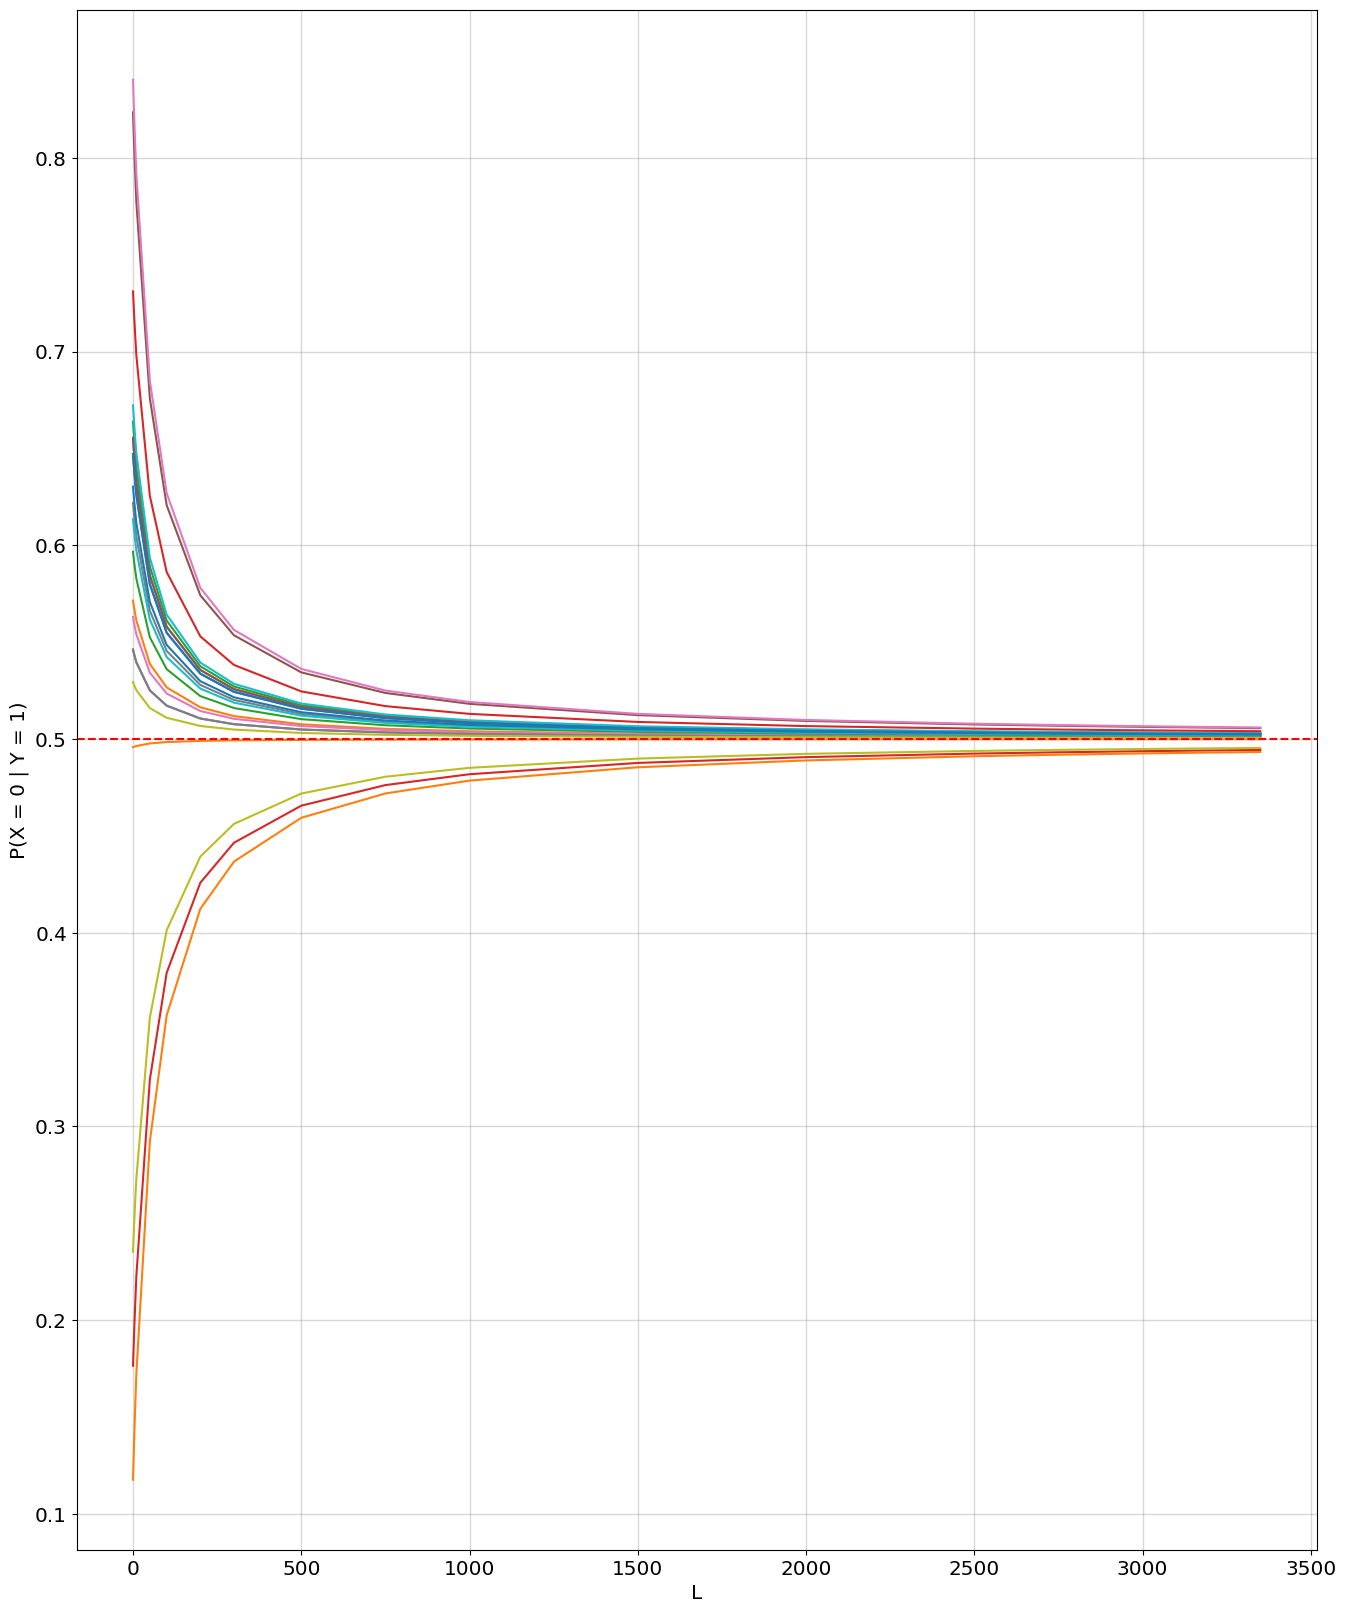

In [338]:
prob_table_0 = []
prob_table_1 = []

for l in L_values:
    params_theta, params_pi, class_vals, probs_0, probs_1 = train_NBC(datasetA_X_categorical, X_dtype="categorical", Y= datasetA_Y,D_categorical=datasetA_D_categorical, L=l,plots=True)
    prob_table_0.append(probs_0)
    prob_table_1.append(probs_1)

# plot the probabilities for some features
prob_table_0 = np.array(prob_table_0)
prob_table_1 = np.array(prob_table_1)

plt.figure(figsize=(16, 20))
for i in range(22):
    plt.plot(L_values, prob_table_0[:, i])

plt.xlabel('L')
plt.ylabel('P(X = 0 | Y = 0)')
plt.axhline(0.5, linestyle='--', color='red')
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.show()


plt.figure(figsize=(16, 20))
for i in range(22):
    plt.plot(L_values, prob_table_1[:, i])

plt.xlabel('L')
plt.ylabel('P(X = 0 | Y = 1)')
plt.axhline(0.5, linestyle='--', color='red')
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.show()

# save the probability tables as csv

prob_table_0 = prob_table_0.round(3)
prob_table_1 = prob_table_1.round(3)

df_0 = pd.DataFrame(prob_table_0)
df_1 = pd.DataFrame(prob_table_1)

csv_file_path = 'prob_table_0.csv'
df_0.to_csv(csv_file_path, index=False, header=False)

csv_file_path = 'prob_table_1.csv'
df_1.to_csv(csv_file_path, index=False, header=False)

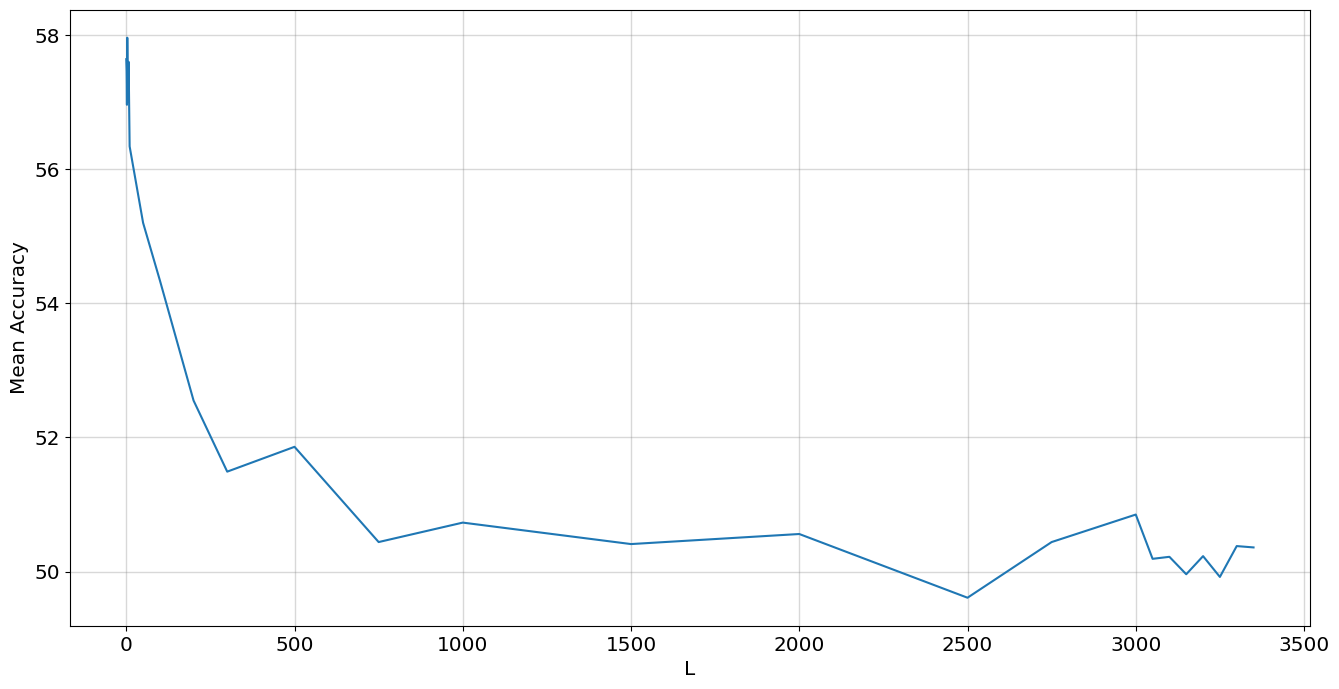

In [339]:
plt.figure(figsize=(16, 8))
plt.plot(L_values, mean_accuracy_for_L_vals)
plt.xlabel('L')
plt.ylabel('Mean Accuracy')
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.show()

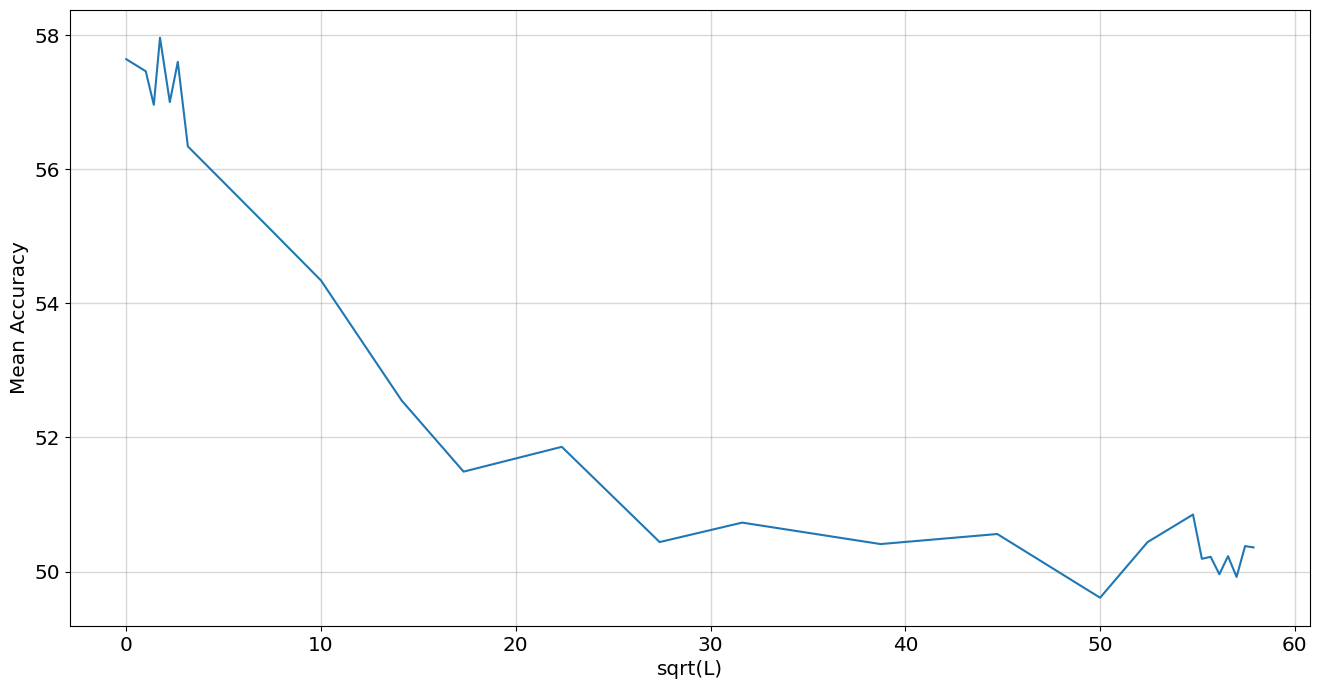

In [340]:
plt.figure(figsize=(16, 8))
plt.plot(np.sqrt(L_values), mean_accuracy_for_L_vals)
plt.xlabel('sqrt(L)')
plt.ylabel('Mean Accuracy')
plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
plt.show()

random classifier

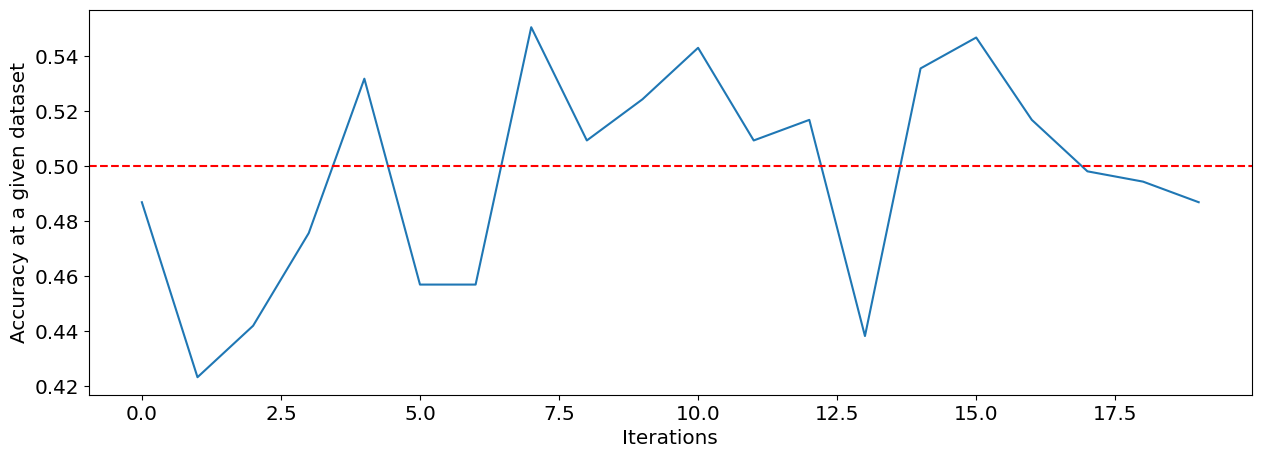

In [341]:
accuracy = []

for i in range(20):
    n = len(datasetA_Y)  # Change this to the desired number of elements
    random_array = np.random.randint(0, 2, size=n)
    accuracy.append(np.sum(datasetA_Y == random_array)/n)

plt.plot(accuracy)
plt.axhline(0.5, linestyle='--', color='red')
plt.xlabel('Iterations')
plt.ylabel('Accuracy at a given dataset')
plt.show()